### NOTE: Neither the lines of code nor text have been proofread

In [1]:
import cv2 as cv
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import Video, HTML


# from __future__ import print_function # Optional
# import argparse  # Only useful if saving to a py file

### Background Subtraction

This method has already been used in various forms for images. Several different algorithms for this method exist for videos; three of them are:

<ul>
    <li> MOG2 (Gaussian mixture-based background/foreground segmentation algorithm)</li>
    <li> KNN (K-nearest neighbors background/foreground segmentation algorithm)</li>
    <li> GMG (Global motion-based background/foreground segmentation algorithm)</li>
</ul>

We shall use just the first one. Also see:
<br>
https://docs.opencv.org/3.4/d1/dc5/tutorial_background_subtraction.html
<br>
https://www.educative.io/answers/background-subtraction-opencv)

In [ ]:
# For use in a py file

# parser = argparse.ArgumentParser(description='This program shows how to use background subtraction methods provided by \
#                                               OpenCV. You can process both videos and images.')
# parser.add_argument('--input', type=str, help='Path to a video or a sequence of image.', default='vtest.avi')
# parser.add_argument('--algo', type=str, help='Background subtraction method (KNN, MOG2).', default='MOG2')
# args = parser.parse_args()
# if args.algo == 'MOG2':
#     backSub = cv.createBackgroundSubtractorMOG2()
# else:
#     backSub = cv.createBackgroundSubtractorKNN()

# capture = cv.VideoCapture(cv.samples.findFileOrKeep(args.input))


**MOG2 (Gaussian mixture-based background/foreground segmentation algorithm)**

In [2]:
capture = cv.VideoCapture('bank_videos/A quiet Japanese street.mp4')

backSub = cv.createBackgroundSubtractorMOG2() # Make sure this is outside the while loop
                                            # or you'll end up with a gray (and not black) background

while capture.isOpened():
    ret, frame = capture.read()
     # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    else:
        fgMask = backSub.apply(frame)
        fgMask = cv.cvtColor(fgMask, cv.COLOR_GRAY2BGR)

        cv.rectangle(frame, (10, 2), (100,20), (255,255,255), -1)
        cv.putText(frame, str(capture.get(cv.CAP_PROP_POS_FRAMES)), (15, 15),
                   cv.FONT_HERSHEY_SIMPLEX, 0.5 , (0,0,0)) 

        cv.imshow('Frame', frame)
        cv.imshow('FG Mask', fgMask)
        
        if cv.waitKey(1) == ord('q'):
            break

In [3]:
capture.release()

In [4]:
cv.destroyAllWindows()

Let's save the background subtraction film

In [11]:
capture = cv.VideoCapture('bank_videos/A quiet Japanese street.mp4')

# Define the codec and create VideoWriter object
codec = cv.VideoWriter_fourcc(*"mp4v")
out = cv.VideoWriter('bank_videos/A quiet Japanese street_backsub.mp4', codec, 30.0, (1280, 720))

backSub = cv.createBackgroundSubtractorMOG2() # Make sure this is outside the while loop
                                            # or you'll end up with a gray (and not black) background

while capture.isOpened():
    ret, frame = capture.read()
     # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    else:
        fgMask = backSub.apply(frame)
        fgMask = cv.cvtColor(fgMask, cv.COLOR_GRAY2BGR)

        cv.rectangle(frame, (10, 2), (100,20), (255,255,255), -1)
        cv.putText(frame, str(capture.get(cv.CAP_PROP_POS_FRAMES)), (15, 15),
                   cv.FONT_HERSHEY_SIMPLEX, 0.5 , (0,0,0)) 

        out.write(fgMask)
        cv.imshow('FG Mask', fgMask)
        
        if cv.waitKey(1) == ord('q'):
            break

Can't receive frame (stream end?). Exiting ...


In [12]:
capture.release()
out.release()

In [13]:
cv.destroyAllWindows()

### Meanshift and Camshift

This enables us track objects in a video. Meanshift and camshift are really two distinct but complementary processes.

**Meanshift**

The makeshift 'window' moves as the object moves, but how does this happen? We use *histogram backprojection*. (The basics of this was explained in *6A_ImageProcessing_p4-HistogramsAndFT*.)

An implementation of meanshift is staged below, using the same video as the background subtraction example.

In [5]:
# Read video
capture = cv.VideoCapture('bank_videos/A quiet Japanese street.mp4')

In [6]:
# Get its size
width = capture.get(cv.CAP_PROP_FRAME_WIDTH)
height = capture.get(cv.CAP_PROP_FRAME_HEIGHT)

w_and_h = [int(width), int(height)]
w_and_h

[1280, 720]

Next, I need to state the (x,y) coordinates of what I'm tracking. Now this is less straightforward because Matplotlib, which is what I would naturally use for this, doesn't work with videos. To get round this, I would have to save the frame as an image file that Matplotlib could read.  Alternatively, I could use OpenCV to get the (x,y) coordinates (without any Matplotlib involvement).

I will start by capturing frame 1 only and saving it as image

In [7]:
capture = cv.VideoCapture('bank_videos/A quiet Japanese street.mp4')

while capture.isOpened():
    ret, frame = capture.read()
     # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    else:
        capture.set(1,1)   # (Indexing system (1st frame=Frame 1), Frame No. to be read) 
        cv.imshow('Frame', frame)
        cv.imwrite('bank_videos/A quiet Japanese street_frame1.png', frame)
        if cv.waitKey(27) == ord('q'):
            break                        

In [8]:
capture.release()

In [9]:
cv.destroyAllWindows()

Let's see our image of frame 1

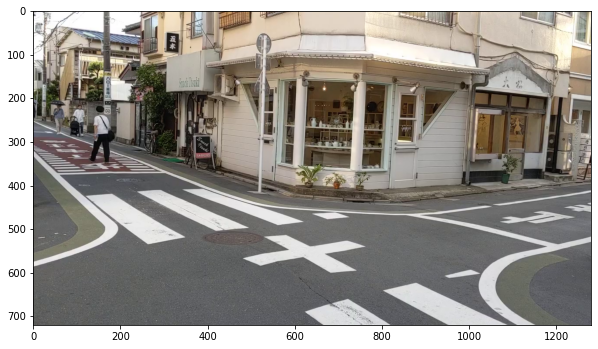

In [10]:
frame1 = cv.imread('bank_videos/A quiet Japanese street_frame1.png')

# View on Matplotlib
rgb_frame1 = cv.cvtColor(frame1, cv.COLOR_BGR2RGB)
plt.figure(figsize=(10,6))
plt.imshow(rgb_frame1)

Notice from the divisions on the axes that the *actual* width and height of the frame from the video (1280 &times; 720) has been preserved (although scaled down to fit the desired space).

Let us now draw a rectangle around the person we want to track. We could try and guess the (x,y) coordinates of the person on the Matplotlib image, or alternatively, get them more quickly and accurately using OpenCV's own facility and then using those coordinates to pinpoint exactly where the rectangle on the Matplotlib image should be drawn, which is the strategy I follow

In [11]:
capture = cv.VideoCapture('bank_videos/A quiet Japanese street.mp4')

font = cv.FONT_HERSHEY_SIMPLEX
def mouseHandler(event, x, y, flags, params):
    if event == cv.EVENT_LBUTTONDOWN:
        print(x, y)
        cv.circle(frame, (x, y), 3, (255, 0, 0), -1)

cv.namedWindow('Frame')
cv.setMouseCallback('Frame', mouseHandler)

while capture.isOpened():
    ret, frame = capture.read()
     # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    else:
        capture.set(1,1)
        cv.imshow('Frame', frame)     
        if cv.waitKey(27) == ord('q'):  # The '27' prevents the video from playing too fast
            break
            
# see https://answers.opencv.org/question/221029/videowriter-recorded-video-play-too-fast/

33 202
71 285


In [12]:
capture.release()

In [13]:
cv.destroyAllWindows()

We shall now draw our (red) rectangle on the Matplotlib image

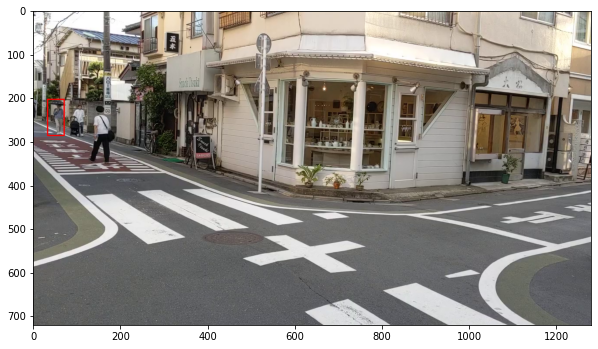

In [14]:
frame1 = cv.imread('bank_videos/A quiet Japanese street_frame1.png')

RED = (0, 0, 255)

p0 = 33, 202  # (x,y)
p1 = 71, 285

cv.rectangle(frame1, p0, p1, RED, 2)

# View on Matplotlib
rgb_frame1 = cv.cvtColor(frame1, cv.COLOR_BGR2RGB)
plt.figure(figsize=(10,6))
plt.imshow(rgb_frame1)

The next step is tracking the person in the rectangle. Now this is going to be tricky to do for multiple reasons. The first is inherent to what is *actually* being tracked. We're in fact tracking the HSV properties within the rectangle. If those properties change (as will inevitably happen as the person moves out of the rectangle), the histogram backprojection changes and causes the rectangle to move till it can regain the HSV properties (or something close to it) it had within it earlier, which will only happen if the rectangle can find the person again; hence, the movement of the rectangle with the person being tracked.

However, the reliance on HSV properties means that if other objects or people have similar HSV properties to the person (or thing) being tracked, then the tracking of that person will fail. In our image, we see that the person we intend to track is wearing what appears to be a gray top and khaki trousers. Unfortunately, the road also appears gray and the walls of the building could be regarded as khaki. Therefore, there's a real likelihood our tracking rectangle will get 'confused' and eventually go *off course*. One solution is to reduce the size of our rectangle so that it only contains the HSV properties of the person with no background included.


Reducing the size of the tracking rectangle creates a new problem though, the 'V' in HSV stands for *value*, which measures the perceived brightness of the object, which is the perceived *intensity* of light transmitted through, or emitted or reflected from the object. This intensity is sometimes referred to as *luminance* (with respect to the response of the human eye). But the luminance of an object can be affected by changes in incident light on that object. Although the person we wish to track is under an umbrella, it is reasonable to assume that the luminance of that person will change as that person walks in and out of the shade of the buildings. This means that although our range for V might be correct in the frame above, as the person walks, it might go out of the range we have set, so that at some point, our reduced tracking rectangle loses the subject. We will return back to this later.

There is yet another problem! Notice the person walking in the opposite direction to the person we are tracking? That person in the opposite direction is closer to us, which as the person walks past the one being tracked, will dramatically and suddenly change the HSV properties to such an extent, that the rectangle will no longer 'know' where to go and will simply go off course. We will therefore start tracking the person of interest *after* the person in the opposite direction has gone past. To identify which frame that happens, knowing the frame rate will be useful

In [11]:
capture = cv.VideoCapture('bank_videos/A quiet Japanese street.mp4')
fps = capture.get(cv.CAP_PROP_FPS)
count = capture.get(cv.CAP_PROP_FRAME_COUNT)

fps_and_c = [int(fps), int(count)]
fps_and_c

[30, 1591]

We now need to play the video with controls visible so as to establish what time the person passes the person to be tracked, and from there, an appropriate frame number can be determined. As we're working on Jupyter Notebook, we can simply play the video with the HTML video element or use IPython's own HTML and video libraries

In [12]:
HTML("""
<video width="320" height="240" controls>
  <source src="bank_videos/A quiet Japanese street.mp4" type="video/mp4">
</video>
""")

I've chosen time = 4 seconds

In [13]:
4*30

120

That is frame 120; we can confirm this

In [14]:
capture = cv.VideoCapture('bank_videos/A quiet Japanese street.mp4')

while capture.isOpened():
    ret, frame = capture.read()
     # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    else:
        capture.set(1,120)   # (Indexing system (1st frame=Frame 1), Frame No. to be read) 
        cv.imshow('Frame', frame)
        cv.imwrite('bank_videos/A quiet Japanese street_frame120.png', frame)
        if cv.waitKey(27) == ord('q'):
            break   

In [15]:
capture.release()

In [16]:
cv.destroyAllWindows()

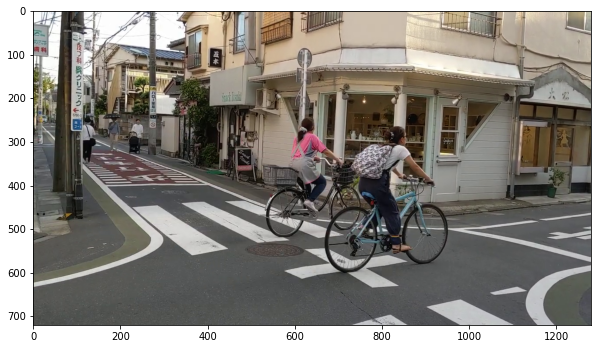

In [17]:
frame120 = cv.imread('bank_videos/A quiet Japanese street_frame120.png')

# View on Matplotlib
rgb_frame120 = cv.cvtColor(frame120, cv.COLOR_BGR2RGB)
plt.figure(figsize=(10,6))
plt.imshow(rgb_frame120)

Now let's reposition our rectangle

In [22]:
capture = cv.VideoCapture('bank_videos/A quiet Japanese street.mp4')

font = cv.FONT_HERSHEY_SIMPLEX
def mouseHandler(event, x, y, flags, params):
    if event == cv.EVENT_LBUTTONDOWN:
        print(x, y)
        cv.circle(frame, (x, y), 3, (255, 0, 0), -1)

cv.namedWindow('Frame')
cv.setMouseCallback('Frame', mouseHandler)

while capture.isOpened():
    ret, frame = capture.read()
     # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    else:
        capture.set(1,120)
        cv.imshow('Frame', frame)     
        if cv.waitKey(27) == ord('q'):
            break

161 234
201 326


In [23]:
capture.release()

In [24]:
cv.destroyAllWindows()

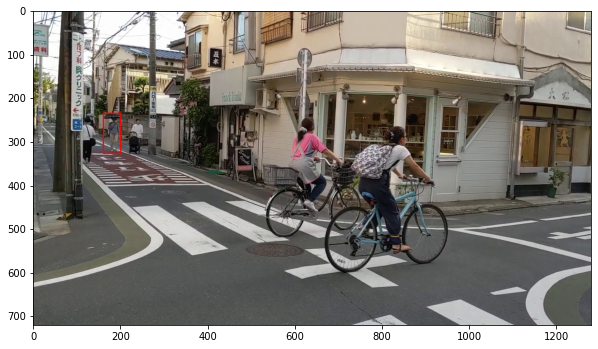

In [26]:
frame120 = cv.imread('bank_videos/A quiet Japanese street_frame120.png')

RED = (0, 0, 255)

p0 = 161, 234  # (x,y)
p1 = 201, 326

cv.rectangle(frame120, p0, p1, RED, 2)

# View on Matplotlib
rgb_frame120 = cv.cvtColor(frame120, cv.COLOR_BGR2RGB)
plt.figure(figsize=(10,6))
plt.imshow(rgb_frame120)

Let us now return to the issue of reducing the size of the rectangle. We want it to only contain the HSV properties of the person being tracked. Our best strategy is to target the top the person is wearing; let us do that now

In [18]:
capture = cv.VideoCapture('bank_videos/A quiet Japanese street.mp4')

font = cv.FONT_HERSHEY_SIMPLEX
def mouseHandler(event, x, y, flags, params):
    if event == cv.EVENT_LBUTTONDOWN:
        print(x, y)
        cv.circle(frame, (x, y), 3, (255, 0, 0), -1)

cv.namedWindow('Frame')
cv.setMouseCallback('Frame', mouseHandler)

while capture.isOpened():
    ret, frame = capture.read()
     # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    else:
        capture.set(1,120)
        cv.imshow('Frame', frame)     
        if cv.waitKey(27) == ord('q'):
            break

180 261
190 275


In [19]:
capture.release()

In [20]:
cv.destroyAllWindows()

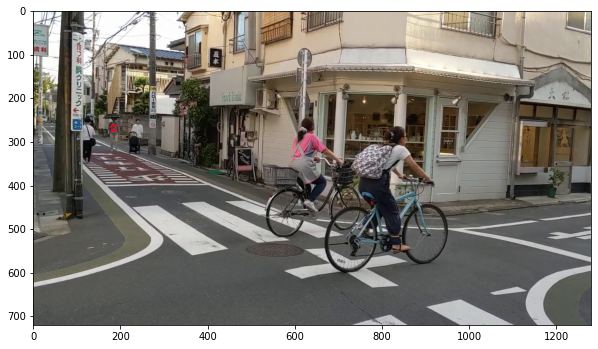

In [21]:
frame120 = cv.imread('bank_videos/A quiet Japanese street_frame120.png')

RED = (0, 0, 255)

p0 = 180, 261  # (x,y)
p1 = 190, 275

cv.rectangle(frame120, p0, p1, RED, 2)

# View on Matplotlib
rgb_frame120 = cv.cvtColor(frame120, cv.COLOR_BGR2RGB)
plt.figure(figsize=(10,6))
plt.imshow(rgb_frame120)

So now, we're going to get the HSV properties of the area of the person within the reduced rectangle. Getting values for all three parts of HSV requires 3D Matplotlib, which is computationally intensive. For now, let's restrict ourselves to 2D as this is quicker. This means that we're only going to get the values for H and S, and give V a default range of 0 to 255

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<AxesSubplot:xlabel='Saturation', ylabel='Hue'>,
 Text(0.5, 0, 'Saturation'),
 Text(0, 0.5, 'Hue'))

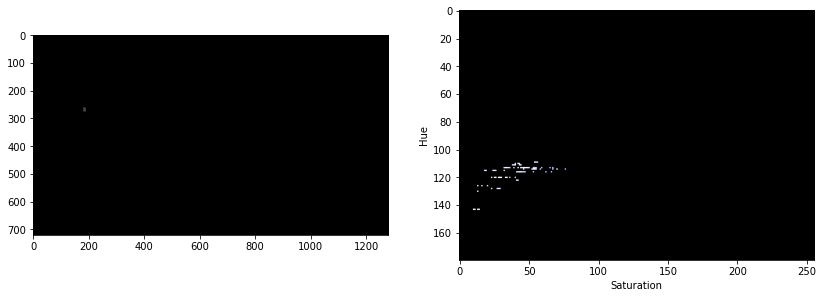

In [18]:
frame120 = cv.imread('bank_videos/A quiet Japanese street_frame120.png')

mask = np.zeros(frame120.shape[:2], np.uint8)
mask[261:275, 180:190] = 255 # [y1:y2, x1:x2]
masked_f120= cv.bitwise_and(frame120,frame120,mask = mask)

hsv_map = np.zeros((180, 256, 3), np.uint8)
h, s = np.indices(hsv_map.shape[:2])
hsv_map[:,:,0] = h
hsv_map[:,:,1] = s
hsv_map[:,:,2] = 255
hsv_map = cv.cvtColor(hsv_map, cv.COLOR_HSV2BGR)


hsv = cv.cvtColor(masked_f120,cv.COLOR_BGR2HSV)
dark = hsv[...,2] < 32
hsv[dark] = 0

hist = cv.calcHist( [hsv], [0, 1], mask, [180, 256], [0, 180, 0, 256] )
vis = hsv_map*hist[:,:,np.newaxis] / 255.0

# View on Matplotlib
rgb_masked_f120 = cv.cvtColor(masked_f120, cv.COLOR_BGR2RGB)
rgb_vis = cv.cvtColor(vis, cv.COLOR_BGR2RGB)
plt.figure(figsize=(14,12))
plt.subplot(1,2,1), plt.imshow(rgb_masked_f120)
plt.subplot(1,2,2), plt.imshow(rgb_vis),plt.xlabel('Saturation'),plt.ylabel('Hue')

We will now use the above information and see if it can track our chosen person as that person walks. We found that the video has 1591 frames and we decided we would start tracking from time = 4 seconds

In [19]:
capture = cv.VideoCapture('bank_videos/A quiet Japanese street.mp4')

start = time.time()
RED = (0, 0, 255)

# Setup initial location of window
x, y, w, h = 180, 261, 10, 14
track_window = (x, y, w, h)

# # Set up the ROI for tracking
ret,frame = capture.read()
roi = frame[y:y+h, x:x+w]
hsv_roi =  cv.cvtColor(roi, cv.COLOR_BGR2HSV)
mask = cv.inRange(hsv_roi, np.array((105, 10, 0)), np.array((145, 80, 255)))
roi_hist = cv.calcHist([hsv_roi],[0],mask,[180],[0,180])
cv.normalize(roi_hist,roi_hist,0,255,cv.NORM_MINMAX)

# Setup the termination criteria, either 10 iteration or move by at least 1 pt
term_crit = ( cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 1 )

while capture.isOpened():
    ret, frame = capture.read()
    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    else:
        # Convert BGR to HSV
        hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
        dst = cv.calcBackProject([hsv],[0],roi_hist,[0,180],1)
        
        if int(time.time() - start) in range(4, 27):    
            # Draw tracking rectangle 
            cv.rectangle(frame, (x,y), (x+w,y+h), RED,2)

            # Apply meanshift to get the new location
            ret, track_window = cv.meanShift(dst, track_window, term_crit)

        cv.imshow('Frame', frame)     
        if cv.waitKey(27) == ord('q'):  # The '27' prevents the video from playing too fast
            break
            
# see https://answers.opencv.org/question/221029/videowriter-recorded-video-play-too-fast/

In [20]:
capture.release()

In [21]:
cv.destroyAllWindows()

Although the rectangle appears at roughly the desired time (allowing for delay in playback), it doesn't track the person. Instead, it initially stays still and eventually drifts to the gray section of wall and stays there. Let's see if getting a more precise V range for the chosen H-S ranges helps; we will now use 3D Matplotlib 

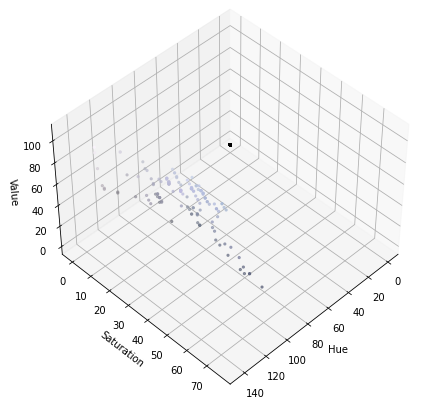

In [29]:
pixel_colors = rgb_masked_f120.reshape((np.shape(rgb_masked_f120)[0]*np.shape(rgb_masked_f120)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

hsv = cv.cvtColor(rgb_masked_f120, cv.COLOR_RGB2HSV)
h, s, v = cv.split(hsv)
fig = plt.figure(figsize=(8,7))

axis = fig.add_subplot(1, 1, 1, projection="3d")
axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".", alpha=0.6)
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
axis.view_init(elev=45, azim=45)

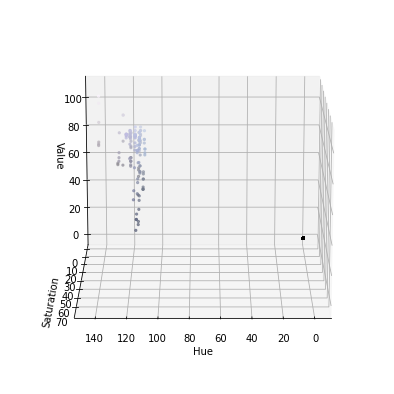

In [30]:
pixel_colors = rgb_masked_f120.reshape((np.shape(rgb_masked_f120)[0]*np.shape(rgb_masked_f120)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

hsv = cv.cvtColor(rgb_masked_f120, cv.COLOR_RGB2HSV)
h, s, v = cv.split(hsv)
fig = plt.figure(figsize=(8,7))

axis = fig.add_subplot(1, 1, 1, projection="3d")
axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".", alpha=0.6)
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
axis.view_init(elev=15, azim=90)

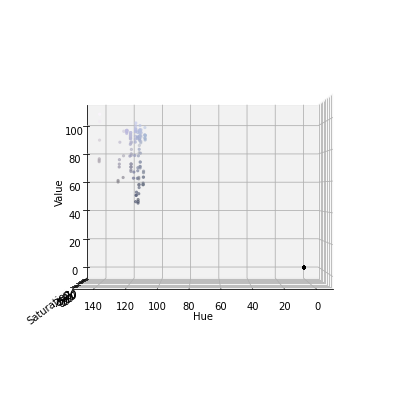

In [237]:
pixel_colors = rgb_masked_f120.reshape((np.shape(rgb_masked_f120)[0]*np.shape(rgb_masked_f120)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

hsv = cv.cvtColor(rgb_masked_f120, cv.COLOR_RGB2HSV)
h, s, v = cv.split(hsv)
fig = plt.figure(figsize=(8,7))

axis = fig.add_subplot(1, 1, 1, projection="3d")
axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".", alpha=0.6)
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
axis.view_init(elev=0, azim=90)

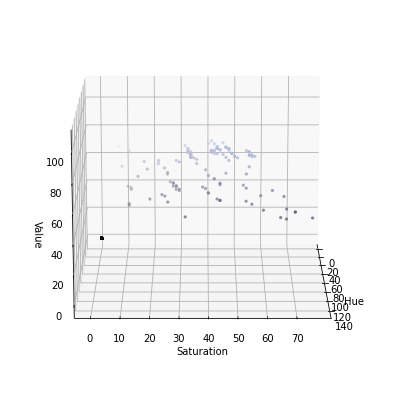

In [31]:
pixel_colors = rgb_masked_f120.reshape((np.shape(rgb_masked_f120)[0]*np.shape(rgb_masked_f120)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

hsv = cv.cvtColor(rgb_masked_f120, cv.COLOR_RGB2HSV)
h, s, v = cv.split(hsv)
fig = plt.figure(figsize=(8,7))

axis = fig.add_subplot(1, 1, 1, projection="3d")
axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".", alpha=0.6)
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
axis.view_init(elev=15, azim=0)

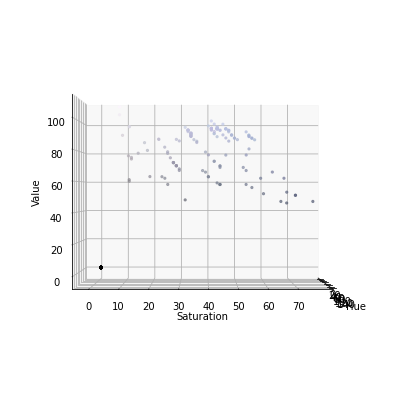

In [250]:
pixel_colors = rgb_masked_f120.reshape((np.shape(rgb_masked_f120)[0]*np.shape(rgb_masked_f120)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

hsv = cv.cvtColor(rgb_masked_f120, cv.COLOR_RGB2HSV)
h, s, v = cv.split(hsv)
fig = plt.figure(figsize=(8,7))

axis = fig.add_subplot(1, 1, 1, projection="3d")
axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".", alpha=0.6)
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
axis.view_init(elev=0, azim=0)

Let's see if this now works; fingers crossed!

In [22]:
capture = cv.VideoCapture('bank_videos/A quiet Japanese street.mp4')

start = time.time()
RED = (0, 0, 255)

# Set up initial location of window
x, y, w, h = 180, 261, 10, 14
track_window = (x, y, w, h)

# Set up the ROI for tracking
ret,frame = capture.read()
roi = frame[y:y+h, x:x+w]
hsv_roi =  cv.cvtColor(roi, cv.COLOR_BGR2HSV)
mask = cv.inRange(hsv_roi, np.array((105, 10, 40)), np.array((145, 80, 100)))
roi_hist = cv.calcHist([hsv_roi],[0],mask,[180],[0,180])
# I wondered if the 5th argument for cv.calcHist() should be [0, 180, 0, 256]
# but this raised an exception

cv.normalize(roi_hist,roi_hist,0,255,cv.NORM_MINMAX)

# Set up the termination criteria, either 10 iteration or move by at least 1 pt
term_crit = ( cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 1 )

while capture.isOpened():
    ret, frame = capture.read()
    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    else:
        # Convert BGR to HSV
        hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
        dst = cv.calcBackProject([hsv],[0],roi_hist,[0,180],1)

        if int(time.time() - start) in range(4, 27):   
            # Draw tracking rectangle 
            cv.rectangle(frame, (x,y), (x+w,y+h), RED,2)

            # Apply meanshift to get the new location
            ret, track_window = cv.meanShift(dst, track_window, term_crit)

        cv.imshow('Frame', frame)     
        if cv.waitKey(27) == ord('q'):
            break

In [23]:
capture.release()

In [24]:
cv.destroyAllWindows()

Sadly, it hasn't made any difference. Despite holding an umbrella, the person's V values have almost certainly gone out of the range set for it as that person walked. Consequently, the tracking rectangle is simply not able to find the combination of H-S-V ranges set.

So, how do we solve this? One hypothesis I considered was as the person moves in and out of the shade of buildings, the combination of H-S-V ranges move across the person's top. Therefore, if we *expanded our tracking rectangle back to its original size*, but kept the combination of H-S-V ranges the same as the reduced tracking rectangle, then as the person moves, and the combination of H-S-V ranges move to another part of the person's top, our tracking rectangle still picks up the combination. Let's try that. 

In [25]:
capture = cv.VideoCapture('bank_videos/A quiet Japanese street.mp4')

start = time.time()
RED = (0, 0, 255)

x, y, w, h = 161, 201, 40, 92  # Bigger rectangle
track_window = (x, y, w, h)

# Set up the ROI for tracking
ret, frame = capture.read()
roi = frame[y:y+h, x:x+w]
hsv_roi =  cv.cvtColor(roi, cv.COLOR_BGR2HSV)
mask = cv.inRange(hsv_roi, np.array((105, 10, 40)), np.array((145, 80, 100)))
roi_hist = cv.calcHist([hsv_roi],[0],mask,[180],[0,180])
cv.normalize(roi_hist,roi_hist,0,255,cv.NORM_MINMAX)

# Set up the termination criteria, either 10 iteration or move by at least 1 pt
term_crit = ( cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 1 )

while capture.isOpened():
    ret, frame = capture.read()
    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    else:
        # Convert BGR to HSV
        hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
        dst = cv.calcBackProject([hsv],[0],roi_hist,[0,180],1)
        
        if int(time.time() - start) in range(4, 20):

            # Apply meanshift to get the new location
            ret, track_window = cv.meanShift(dst, track_window, term_crit)
        
            # Draw tracking rectangle
            x, y, w, h = track_window
            cv.rectangle(frame, (x,y), (x+w,y+h), RED,2)

        cv.imshow('Frame', frame)     
        if cv.waitKey(12) == ord('q'):  # Changing 27 to 12 appears to have helped
            break

In [26]:
capture.release()

In [27]:
cv.destroyAllWindows()

It worked!

For more on luminance, see:
<br>
https://ergo.human.cornell.edu/studentdownloads/DEA3500notes/Lighting/lightingnotes1.html

And the file:
<br>
*6C_VideoAnalysis_p1_Radiometry.pdf*

And to see another code example of meanshift, see:
<br>
https://docs.opencv.org/3.4/d7/d00/tutorial_meanshift.html

On to camshift!

**Camshift**

Did you notice that as our subject walked and the tracking rectangle tracked, that rectangle stayed the same size and the person eventually outgrew the size of the rectangle as she got nearer to the observer. We can use CAMshift (Continuously Adaptive Meanshift) to update the size of the window. The theory behind that is in https://docs.opencv.org/3.4/d7/d00/tutorial_meanshift.html

When I tried this, I noticed that although the rectangle updated its size as the person walked, it tended to restrict its size to the person's top, which was the region I had targeted for tracking. I also found that the tracking rectangle first needed to appear a little later than 4 seconds.

In [85]:
capture = cv.VideoCapture('bank_videos/A quiet Japanese street.mp4')

start = time.time()
RED = (0, 0, 255)

x, y, w, h = 161, 201, 40, 92
track_window = (x, y, w, h)

# Set up the ROI for tracking
ret, frame = capture.read()
roi = frame[y:y+h, x:x+w]
hsv_roi =  cv.cvtColor(roi, cv.COLOR_BGR2HSV)
mask = cv.inRange(hsv_roi, np.array((105, 10, 40)), np.array((145, 80, 100)))
roi_hist = cv.calcHist([hsv_roi],[0],mask,[180],[0,180])
cv.normalize(roi_hist,roi_hist,0,255,cv.NORM_MINMAX)

# Set up the termination criteria, either 10 iteration or move by at least 1 pt
term_crit = ( cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 1 )

while capture.isOpened():
    ret, frame = capture.read()
    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    else:
        # Convert BGR to HSV
        hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
        dst = cv.calcBackProject([hsv],[0],roi_hist,[0,180],1)
        
        if int(time.time() - start) in range(6, 20):

            # Apply camshift to get the new location
            ret, track_window = cv.CamShift(dst, track_window, term_crit)
        
            # Draw tracking rectangle
            pts = cv.boxPoints(ret)
            pts = np.int0(pts)
            cv.polylines(frame,[pts],True, RED,2)

        cv.imshow('Frame', frame)     
        if cv.waitKey(12) == ord('q'):  # Changing 27 to 12 appears to have helped
            break

In [86]:
capture.release()

In [87]:
cv.destroyAllWindows()

Let's save this

In [109]:
capture = cv.VideoCapture('bank_videos/A quiet Japanese street.mp4')

# Define the codec and create VideoWriter object
codec = cv.VideoWriter_fourcc(*"mp4v")
out = cv.VideoWriter('bank_videos/A quiet Japanese street_tracked.mp4', codec, 30.0, (1280, 720))

start = time.time()
RED = (0, 0, 255)

x, y, w, h = 161, 201, 40, 92
track_window = (x, y, w, h)

# Set up the ROI for tracking
ret, frame = capture.read()
roi = frame[y:y+h, x:x+w]
hsv_roi =  cv.cvtColor(roi, cv.COLOR_BGR2HSV)
mask = cv.inRange(hsv_roi, np.array((105, 10, 40)), np.array((145, 80, 100)))
roi_hist = cv.calcHist([hsv_roi],[0],mask,[180],[0,180])
cv.normalize(roi_hist,roi_hist,0,255,cv.NORM_MINMAX)

# Set up the termination criteria, either 10 iteration or move by at least 1 pt
term_crit = ( cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 1 )

while capture.isOpened():
    ret, frame = capture.read()
    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    else:
        # Convert BGR to HSV
        hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
        dst = cv.calcBackProject([hsv],[0],roi_hist,[0,180],1)
        
        if int(time.time() - start) in range(7, 22):  # 6 is altered to 7

            # Apply camshift to get the new location
            ret, track_window = cv.CamShift(dst, track_window, term_crit)
        
            # Draw tracking rectangle
            pts = cv.boxPoints(ret)
            pts = np.int0(pts)
            cv.polylines(frame,[pts],True, RED,2)
            
        # write the frame
        out.write(frame)
        cv.imshow('Frame', frame)     
        if cv.waitKey(7) == ord('q'):  # Changing 12 to 7 appears with timing
            break

Can't receive frame (stream end?). Exiting ...


In [110]:
capture.release()
out.release()

In [111]:
cv.destroyAllWindows()

Done!